In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Data:

In [29]:
training_file = "/content/gdrive/MyDrive/Dataset/German Traffic/train.p"
testing_file = "/content/gdrive/MyDrive/Dataset/German Traffic/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


# Load CSV:

In [30]:
sign_name_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/German Traffic/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


# Menampilkan Data:

In [31]:
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Menentukan fitur dan label untuk data pelatihan

In [32]:
X, y = train['features'], train['labels']

# Mengubah List menjadi array numpy

In [33]:
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

(34799, 32, 32, 3) (34799,)


# Menentukan fitur dan label untuk data pengujian

In [34]:
X_test, y_test = test['features'], test['labels']

# Mengubah List menjadi array numpy (Data pengujian)

In [35]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


# Split Training Data into Train and Validation Sets

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


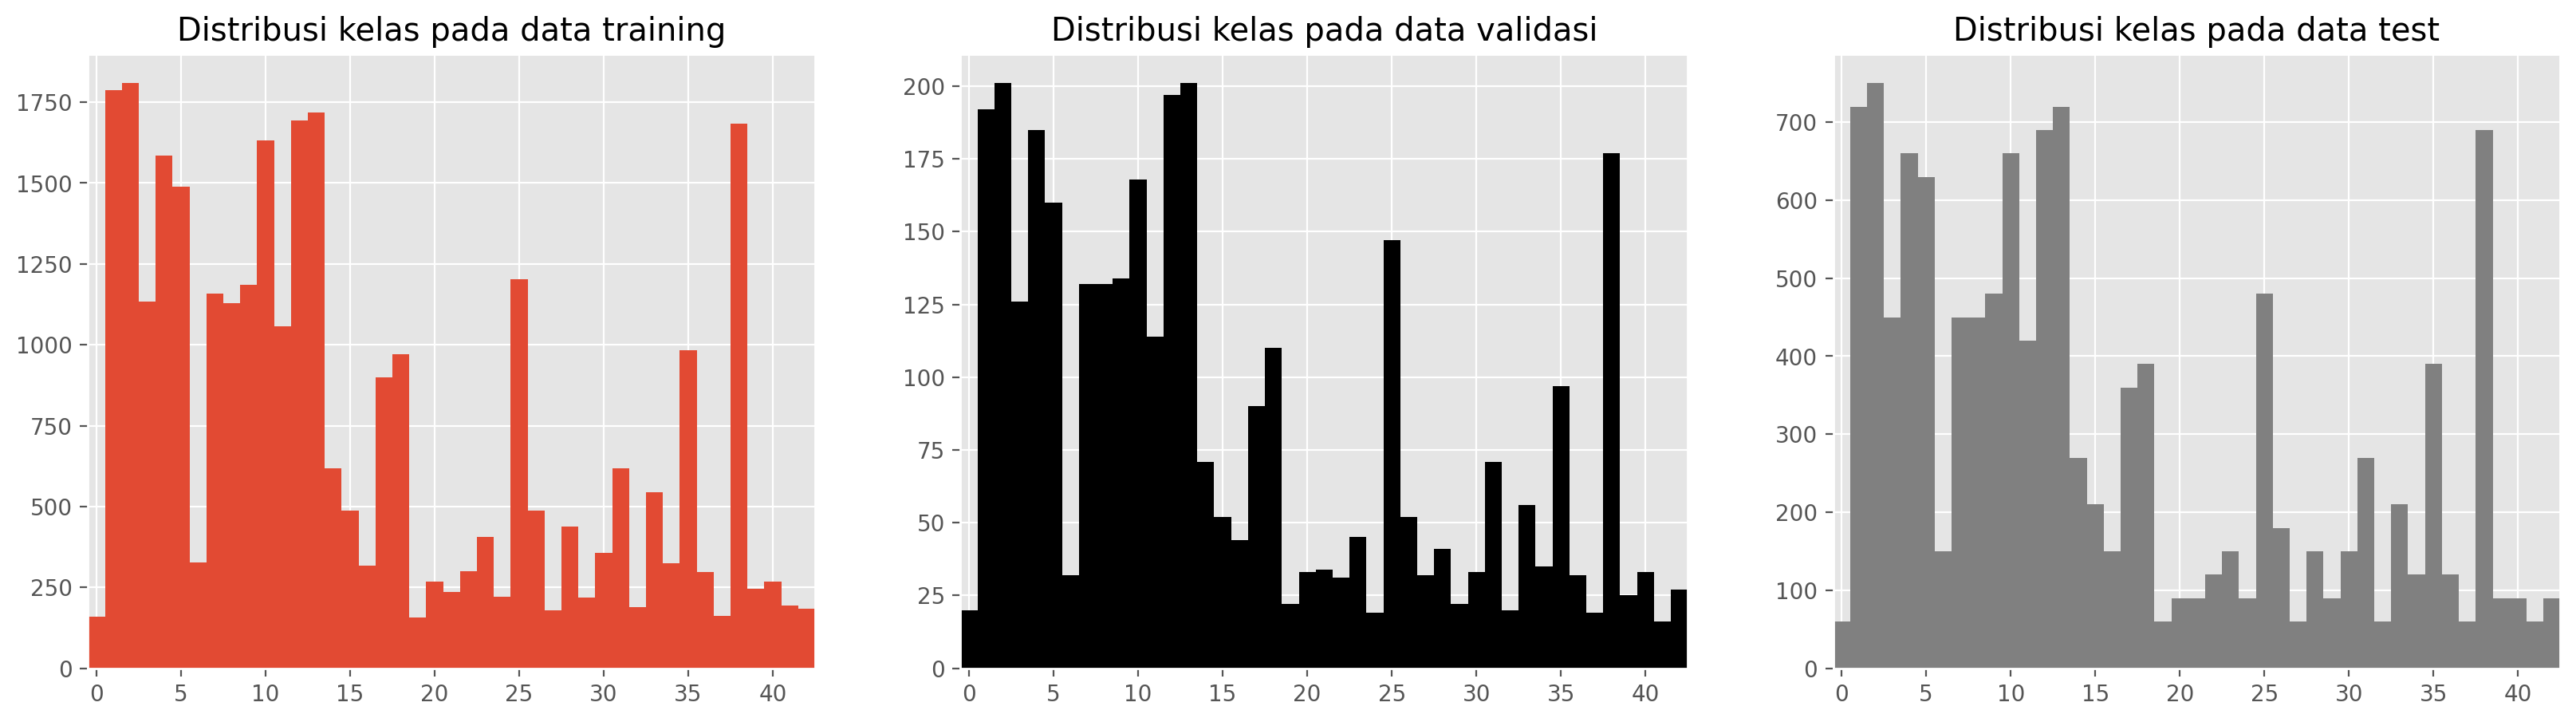

In [37]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

# Mengubah Label menjadi One-Hot Encoding

In [38]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical (y_train,43)
y_val = to_categorical(y_val,43)

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

# Menentukan model CNN

In [40]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 8s 6ms/step - loss: 1.6932 - accuracy: 0.5729 - val_loss: 0.3436 - val_accuracy: 0.9023
Epoch 2/25
979/979 [==============================] - 5s 5ms/step - loss: 0.5765 - accuracy: 0.8291 - val_loss: 0.1957 - val_accuracy: 0.9523
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.3975 - accuracy: 0.8846 - val_loss: 0.1401 - val_accuracy: 0.9615
Epoch 4/25
979/979 [==============================] - 6s 6ms/step - loss: 0.3121 - accuracy: 0.9100 - val_loss: 0.1014 - val_accuracy: 0.9727
Epoch 5/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2673 - accuracy: 0.9225 - val_loss: 0.0911 - val_accuracy: 0.9750
Epoch 6/25
979/979 [==============================] - 6s 6ms/step - loss: 0.2353 - accuracy: 0.9327 - val_loss: 0.0960 - val_accuracy: 0.9773
Epoch 7/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2237 - accuracy: 0.9385 - val_loss: 0.0672 - val_accuracy: 0.9839
Epoch 

In [44]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


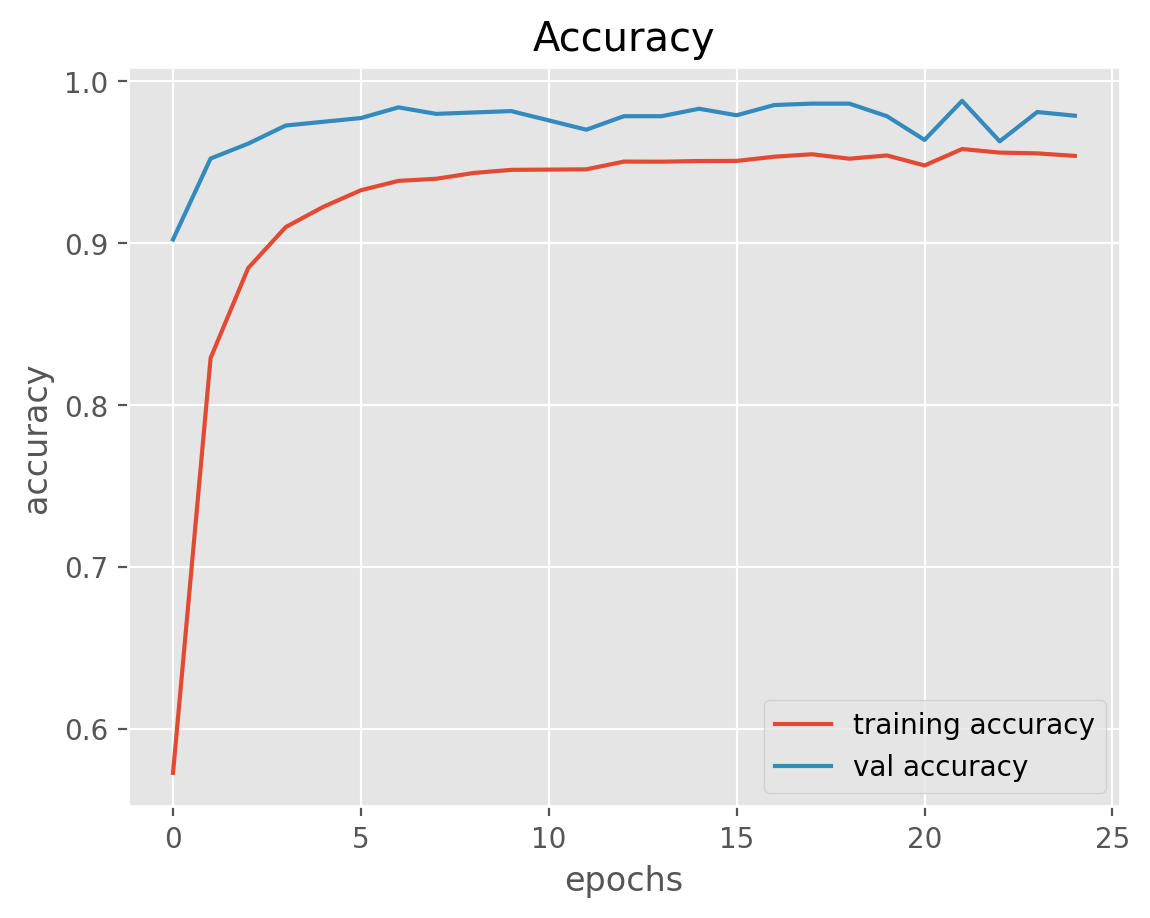

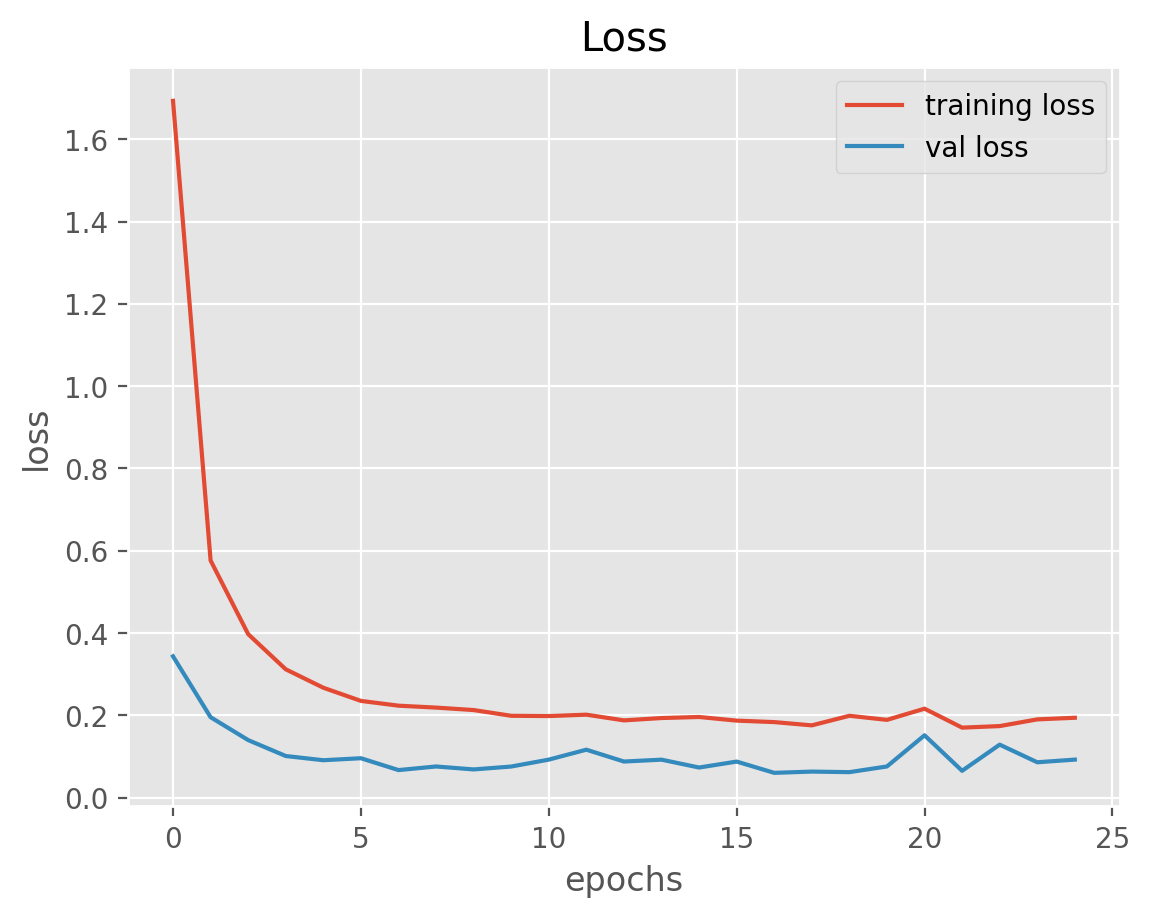

In [45]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 1s 2ms/step


0.9397466349960412

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90        60
           1       0.93      0.95      0.94       720
           2       0.96      0.96      0.96       750
           3       0.90      0.92      0.91       450
           4       0.96      0.92      0.94       660
           5       0.87      0.94      0.91       630
           6       0.97      0.80      0.88       150
           7       0.96      0.95      0.96       450
           8       0.92      0.94      0.93       450
           9       0.97      1.00      0.98       480
          10       0.99      0.98      0.99       660
          11       0.89      0.96      0.92       420
          12       0.97      0.97      0.97       690
          13       0.99      0.98      0.99       720
          14       0.97      0.98      0.97       270
          15       0.90      0.99      0.94       210
          16       0.99      0.99      0.99       150
          17       0.98    